# VT2

In [1]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Importing Packets for the Genetic Algorithm
import random
from deap import base, creator, tools

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation
Parameters

In [2]:
Param = {
    "Dt0": 22561132,  # Demand at t0
    "dt": 1,  # Steptime in Years
    "Fth": 20,  # Time Horizon of Forecasts in Steptime
    "Forecasts": 100,  # Number of Forecasts
    "mu": 0.042754330256447565,
    "sigma": 0.05813761525452841,
    "r_D": 0.1,  # Revenues per Unit of Demand per Period
    "r_K": 1,  # Revenues per Unit of Capacity per Period
    "r_K_rent": 0.1,  # Rental Revenues per Unit of Capacity per Period
    "co_K": 0.34,  # Operational costs per unit of capacity per period
    "co_D": 0.1,  # Operational cost per unit of demand per period
    "ci_K": 600000,  # Installation cost per unit of capacity
    "discount": 0.05,  # Discount factor
    "EoS": 0.8,  # EoS factor
    "delta_K0": 0,  # Initial Value for delta_K
    "h": 1,  # h
    "K0": 25000000,  # Initial Capacity
    "p_dock": 0.8,  # Percentage of Pax using Dock Stands rather than Bus Gates
    "p_schengen": 0.8,  # Percentage of Pax travelling within Schengen Area
    "p_Dok_A_B": 0.5,  # Percentage of Pax travelling from Dock
    "PAXATM": 120,  # average number of passengers carried per air traffic movement
    "delta_K": np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0]),
    "allowed_values": np.array([0, 6, 8, 10]),
    "population": 1000,
    "DHL_factor_20": 0.0003,
    # "theta": 9000000,
}

# # Paremeters von Wate:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 7  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 0.34  # Operational costs per unit of capacity per period
# co_D = 0  # Operational cost per unit of demand per period
# ci_K = 600000  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.9  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

# # Paremeters:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 2  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 1  # Operational costs per unit of capacity per period
# co_D = 1  # Operational cost per unit of demand per period
# ci_K = 7  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.95  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

Creating a Scenario

In [3]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(Param)
# Round values up for further Calculation
Demand = np.ceil(Scenarios)
# D_rounded = np.ceil(Demand / 1000000)

Geometric Brownian motion Formula

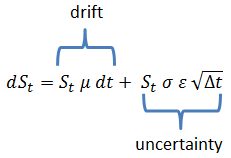

## Calulation of the ENPV

In [4]:
# Example Value for delta_K
delta_K_Example = Param["delta_K"]

K_Example = fn.Capacity(Param["K0"], delta_K_Example, Param["Forecasts"])

ENPV_Example = fn.ENPV_calculation(delta_K_Example, Param, Demand)
print("Example ENPV:", ENPV_Example)

Example ENPV: 302292168.95813656


## Optimization of the ENPV with a GA

In [5]:
Optimized_delta_K = fn.GA(Param, Demand)
print("Best individual:", Optimized_delta_K)
print("Best ENPV:", Optimized_delta_K.fitness.values[0])

Best individual: [ 0  0  8  0  8  0  0  0  6 10  0  0  0  8  0  0  0  0  0  0]
Best ENPV: 318919198.4531185


### Plot of the Optimization Results

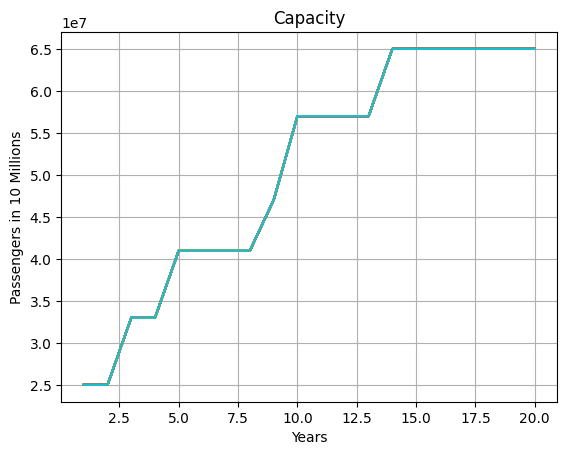

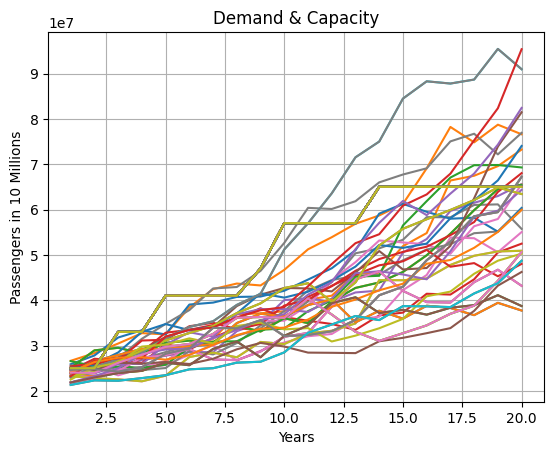

<Figure size 640x480 with 0 Axes>

In [6]:
Optimized_K = np.array(fn.Capacity(Param["K0"], Optimized_delta_K, Param["Forecasts"]))
Optimized_K_Plot = np.vstack([Demand, Optimized_K])

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Optimized_K,
    Param["Fth"],
    True,
    "Capacity",
    "Passengers in 10 Millions",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Optimized_K_Plot,
    Param["Fth"],
    True,
    "Demand & Capacity",
    "Passengers in 10 Millions",
    100,
)

## Calculation of the Flexible NPV Decision Rule

In [7]:
def Decision_Rule(K0, D, theta, condition):
    """
    This function creates new delta capacity vector while considering a decision rule

    Args:
        K0 (int): Initial Capacity
        D (ndarray): Demand Matrix
        theta (ndarray): Capacity Change Vector
        condition (int): Undercapacity at which Capacity will be increased

    Returns:
        delta_K_Flex (ndarray): delta capacity vector considering a decision rule

    To call this function use the following syntax:
        Decision_Rule(K0, D, theta, condition)
    """
    # Creation of an array with the same shape as D initialized with K0
    K_Flex = np.full(D.shape, K0, dtype=D.dtype)

    # Initialize the first column with K0
    K_Flex[:, 0] = K0

    # For loop to iterate over all values of a Scenario
    for t in range(1, D.shape[1]):  # Start from t=1
        # Calculate the Difference Matrix
        diff = K_Flex[:, t - 1] - D[:, t]
        # Create an Index Matrix with the Condition for Overcapacity
        over_capacity = np.greater_equal(diff, condition).astype(int)
        # Create an Index Matrix with the Condition for Undercapacity
        under_capacity = np.less(diff, condition).astype(int)
        # Update K_Flex for the next iteration
        K_Flex[:, t] = over_capacity * K_Flex[:, t - 1] + under_capacity * (
            K_Flex[:, t - 1] + theta[t] * 1000000
        )

        delta_K = np.diff((K_Flex / 1000000) - 25)
        delta_K_Flex = np.insert(delta_K, 0, 0, axis=1)

    return delta_K_Flex


def Capacity2(K0, delta_K):
    """
    This function returns the Capacity in Matrix format for a given initial
    capacity (K0) and delta capacity vector (delta_K)

    Args:
        K0 (int): Initial Capacity
        delta_K (ndarray): Delta Capacity Vector

    Returns:
        K (ndarray): Capacity Matrix

    To call this function use the following syntax:
        Capacity2(K0, delta_K)
    """
    # Create a cumulative sum array starting from K0 for each forecast
    K = K0 + np.cumsum(delta_K, axis=1) * 1000000

    return K


def NPV_Flexible(delta_K, Param):
    """
    This function calculates the Net Present Value for the flexible case by calling the
    Capacity and NPV calculation functions

    Args:
        delta_K (ndarray): Delta Capacity Vector
        Param (dict): Parameter dictionary

    Returns:
        NPV (ndarray): Net Present Value for the Flexible Case

    To call this function use the following syntax:
        NPV_Flexible(delta_K, Param)
    """
    K0 = Param["K0"]
    K_Flex = Capacity2(K0, delta_K)
    NPV = fn.NPV_calculation(K_Flex, Demand, delta_K, Param)
    return NPV


def ENPV_Flexible(theta, condition, Param, D):
    """
    This function calculates the Expected Net Present Value by calling the Decision Rule
    and NPV Flexible functions

    Args:
        theta (ndarray): Capacity increase value
        condition (integer): Condition for Capacity increase (difference of K and D)
        Param (dict): Parameter Dictionary
        D (ndarray): Demand Matrix

    Returns:
        ENPV (ndarray): Expected Net Present Value in the Flexible case

    To call this function use the following syntax:
        ENPV_Flexible(theta, condition, Param, D)
    """
    K0 = Param["K0"]
    delta_K = Decision_Rule(K0, D, theta, condition)
    NPV = NPV_Flexible(delta_K, Param)
    ENPV = np.mean(NPV)
    return ENPV

## Optimization of the Decision Rule with a Second GA

In [8]:
def GA2(Param, D):
    """
    This is a Genetic Algorithm seeking to find an optimal capacity change vector
    (theta) to maximise the ENPV

    Args:
        Param (dict): Parameter Dictionary
        D (ndarray): Demand Matrix

    Returns:
        delta_K2 (ndarray): Optimal Capacity Change Vector (theta)


    To call this function use the following syntax:
        GA2(Param, D)
    """
    # Define the vector of values
    value_vector2 = Param["allowed_values"]
    condition2 = 0

    # Create the DEAP framework
    creator.create("FitnessMax2", base.Fitness, weights=(1.0,))
    creator.create("Individual2", np.ndarray, fitness=creator.FitnessMax2)
    toolbox2 = base.Toolbox()

    # Define the individual initialization function
    def init_individual2():
        return np.array([random.choice(value_vector2) for _ in range(Param["Fth"])])

    # Register the initialization function and the population function
    toolbox2.register(
        "individual2", tools.initIterate, creator.Individual2, init_individual2
    )
    toolbox2.register("population2", tools.initRepeat, list, toolbox2.individual2)

    # Mutation operator
    def mutate_individual2(individual2):
        for i in range(len(individual2)):
            if random.random() < 0.2:  # Mutation probability
                individual2[i] = random.choice(value_vector2)

    # Register the mutation operator
    toolbox2.register("mutate2", mutate_individual2)

    # Define the evaluation function
    def evaluate2(individual2, condition2=condition2, Param=Param):
        return (ENPV_Flexible(individual2, condition=condition2, Param=Param, D=D),)

    toolbox2.register("evaluate2", evaluate2)

    # Define the genetic operators
    toolbox2.register("mate2", tools.cxTwoPoint)
    toolbox2.register("select2", tools.selTournament, tournsize=3)

    # Set up the genetic algorithm
    population2 = toolbox2.population2(n=Param["population"])
    cxpb2, mutpb2, ngen2 = 0.5, 0.1, 10

    # Perform the evolution
    for gen2 in range(ngen2):
        offspring2 = toolbox2.select2(population2, len(population2))
        offspring2 = list(map(toolbox2.clone, offspring2))

        for child21, child22 in zip(offspring2[::2], offspring2[1::2]):
            if random.random() < cxpb2:
                toolbox2.mate2(child21, child22)
                del child21.fitness.values
                del child22.fitness.values

        for mutant2 in offspring2:
            if random.random() < mutpb2:
                toolbox2.mutate2(mutant2)
                del mutant2.fitness.values

        invalid_ind2 = [ind2 for ind2 in offspring2 if not ind2.fitness.valid]
        fitnesses2 = map(toolbox2.evaluate2, invalid_ind2)

        for ind2, fit2 in zip(invalid_ind2, fitnesses2):
            ind2.fitness.values = fit2

        population2[:] = offspring2

    # Get the best individual
    best_ind2 = tools.selBest(population2, 1)[0]

    return best_ind2

In [9]:
theta_max = GA2(Param, Demand)
print(theta_max)
print(ENPV_Flexible(theta_max, 0, Param, Demand))

import warnings

warnings.filterwarnings(
    "ignore", message="A class named 'FitnessMax' has already been created"
)
warnings.filterwarnings(
    "ignore", message="A class named 'Individual' has already been created"
)

[ 0 10  8 10 10 10 10  8  8 10 10  8  8 10  8 10 10  8  6  0]
324363887.1390001


Finding the Optimal Capacity increase value

In [10]:
# def Evaluation_theta(condition, Param):
#     lower = 1000000
#     upper = 10000000  # upper bound in arange is exclusive
#     stepsize = 50000
#     max_enpv = [float("-inf")]  # Initialize max ENPV to negative infinity
#     max_theta = None

#     for theta in np.arange(lower, upper, stepsize):
#         theta_vector = np.random.choice(theta)
#         ENPV = ENPV_Flexible(theta, condition, Param)
#         if ENPV > max_enpv:
#             max_enpv = ENPV
#             max_theta = theta

#     return max_enpv, max_theta


# # # Example usage:
# condition = 0
# ENPV_max, theta_max = Evaluation_theta(condition, Param)
# print("Maximum ENPV:", ENPV_max)
# print("Corresponding deltaK_theta:", theta_max)

Finding the Optimal Condition

In [11]:
def Evaluation2(D, theta, Param):
    """
    This function iterates over all possible conditions to find the optimal value which
    maximises the ENPV Flexible function

    Args:
        D (ndarray): Demand Matrix
        theta (ndarray): Capacity Change Vector
        Param (dict): Parameter Dictionary

    Returns:
        max_enpv (int): Maximum ENPV
        condition_max (int): Condition at which ENPV is maximal

    To call this function use the following syntax:
        Evaluation2(D, theta, Param)
    """

    lower = -200000
    upper = +200000  # upper bound in arange is exclusive
    stepsize = 1000
    max_enpv = float("-inf")  # Initialize max ENPV to negative infinity
    condition_max = None

    for condition in np.arange(lower, upper, stepsize):

        ENPV = ENPV_Flexible(theta, condition, Param, D)
        if ENPV > max_enpv:
            max_enpv = ENPV
            condition_max = condition

    return max_enpv, condition_max

In [12]:
ENPV_max2, condition_max = Evaluation2(Demand, theta_max, Param)
print("Maximum ENPV:", ENPV_max2)
print("Corresponding condition value:", condition_max)

Maximum ENPV: 324363887.1390001
Corresponding condition value: -6000


In [13]:
# def Evaluation(Param):
#     lower_theta = 1000000
#     upper_theta = 10000000
#     stepsize_theta = 100000
#     lower_cond = -500000
#     upper_cond = 500000
#     stepsize_cond = 50000
#     max_enpv = float("-inf")  # Initialize max ENPV to negative infinity
#     max_theta = None

#     for condition in np.arange(lower_cond, upper_cond, stepsize_cond):
#         for theta in np.arange(lower_theta, upper_theta, stepsize_theta):
#             ENPV = ENPV_Flexible(theta, condition, Param)
#             if ENPV > max_enpv:
#                 max_enpv = ENPV
#                 max_theta = theta
#                 max_cond = condition

#     return max_enpv, max_theta, max_cond


# ENPV_max, theta_max, max_cond = Evaluation(Param)
# print("Maximum ENPV:", ENPV_max)
# print("Corresponding theta:", theta_max)
# print("Corresponding condition:", max_cond)

In [14]:
delta_K_Flex = Decision_Rule(Param["K0"], Demand, theta_max, condition_max)
K_Flex = Capacity2(Param["K0"], delta_K_Flex)
NPV_Flex = NPV_Flexible(delta_K_Flex, Param)
ENPV_Flex = ENPV_Flexible(theta_max, condition_max, Param, Demand)
print("ENPV Decision Rule: ", ENPV_Flex)

ENPV Decision Rule:  324363887.1390001


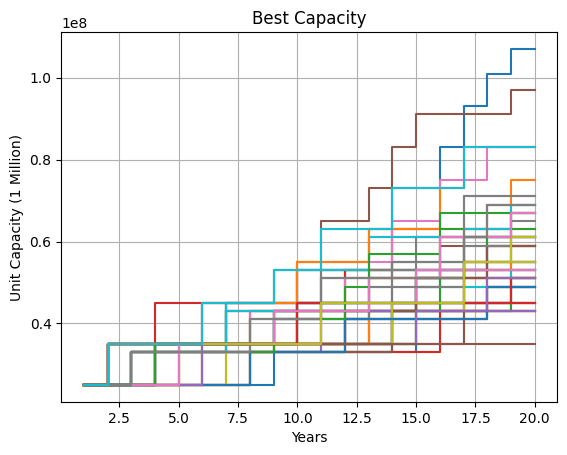

<Figure size 640x480 with 0 Axes>

In [21]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    K_Flex,
    Param["Fth"],
    False,
    "Best Capacity",
    "Unit Capacity (1 Million)",
    90,
)

## Target Curves

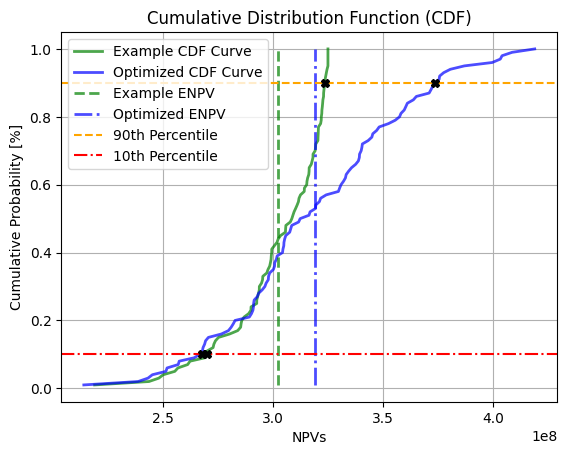

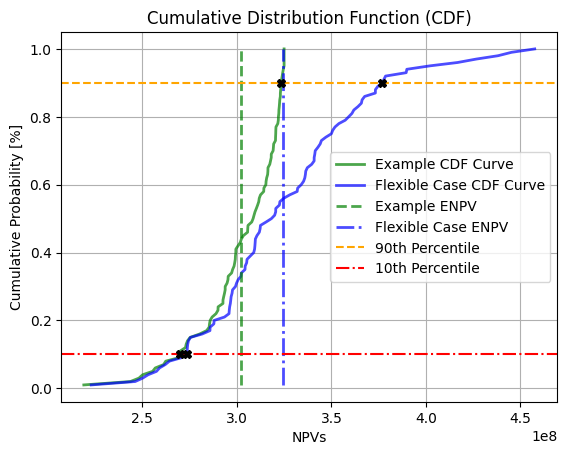

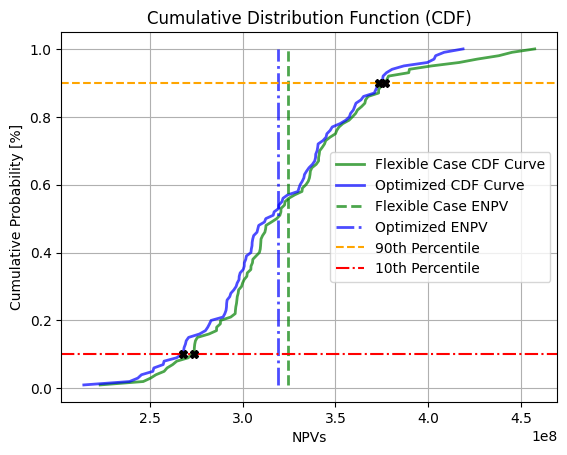

Percentiles (10 and 90) for Decision Rule + Optimized NPVs = [273600220.66958153, 376900851.2882597, 267886856.05334496, 373518032.3952283]


In [16]:
# Plotting the CDF for the First Decision Rule
Percentiles = fn.CDF_Plot(
    fn.NPV_calculation(K_Example, Demand, delta_K_Example, Param),
    fn.NPV_calculation(
        Optimized_K,
        Demand,
        Optimized_delta_K,
        Param,
    ),
    "Example",
    "Optimized",
)

Percentiles1 = fn.CDF_Plot(
    fn.NPV_calculation(K_Example, Demand, delta_K_Example, Param),
    NPV_Flex,
    "Example",
    "Flexible Case",
)


Percentiles2 = fn.CDF_Plot(
    NPV_Flex,
    fn.NPV_calculation(Optimized_K, Demand, Optimized_delta_K, Param),
    "Flexible Case",
    "Optimized",
)
# # Plotting the CDF for the Second Decision Rule
# Percentiles1 = fn.CDF_Plot(Traditional_NPV, Flex_NPV_est)
# print("Percentiles (10 and 90) for Example + Optimized NPVs =", Percentiles)
# print("Percentiles (10 and 90) for Example + Decision Rule NPVs =", Percentiles1)
print("Percentiles (10 and 90) for Decision Rule + Optimized NPVs =", Percentiles2)

Calcualtion of the Desing Hour Load (DHL) and Docking Stand Demand

In [17]:
## Contact Stand Demand (ZRH has 75, but not all can be used at once)
## Dock A has 17 Contact and 16 Bus Gates

No_Docks = fn.Dockstands(K_Flex, Param)
print("Contactstand demad:\n", No_Docks)

Contactstand demad:
 [[20. 28. 28. ... 36. 36. 36.]
 [20. 20. 27. ... 35. 40. 40.]
 [20. 20. 20. ... 49. 54. 54.]
 ...
 [20. 28. 28. ... 43. 43. 43.]
 [20. 20. 20. ... 27. 27. 27.]
 [20. 28. 28. ... 44. 44. 44.]]


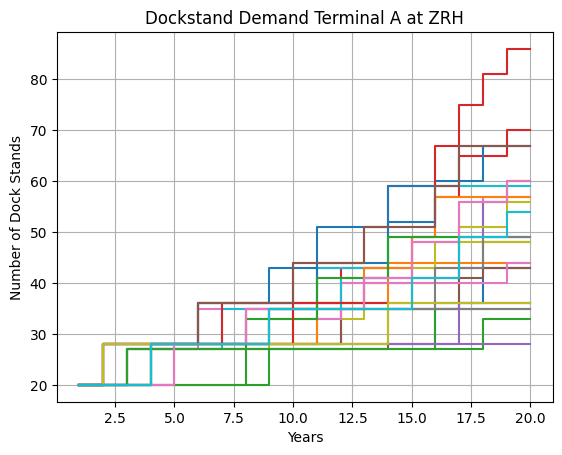

<Figure size 640x480 with 0 Axes>

In [22]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    No_Docks,
    Param["Fth"],
    False,
    "Dockstand Demand Terminal A at ZRH",
    "Number of Dock Stands",
    30,
)

### Stopping the Runtime

In [19]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", round(total_run_time, 2), "s")

Total Runtime = 11.72 s
